In [13]:
import pandas as pd
from sklearn import linear_model
import numpy as np
from matplotlib import pyplot as plt
import ants
import os
from tqdm import tqdm
import statistics
import statsmodels.api as sm

In [14]:
#read in symptom patient data and slice out important columns
df = pd.read_csv('/mmfs1/data/pijarj/SFARI_data/sfari_df_S121.csv')
df.columns
df[['ados_css', 'rrb_css', 'sa_css']]

,ados_css,rrb_css,sa_css
0,2.0,5.0,3.0
1,2.0,1.0,2.0
2,2.0,6.0,2.0
3,2.0,1.0,4.0
4,1.0,1.0,1.0
...,...,...,...
116,NaN,NaN,NaN
117,NaN,NaN,NaN
118,NaN,NaN,NaN
119,1.0,1.0,1.0


In [15]:
#load in diffmat data
atlas = ants.image_read('/mmfs1/data/pijarj/BC-ORG-Data/YeoAtlas/Atlas_parc-7n_2mm.nii')
diffmat = np.load('/mmfs1/data/pijarj/SFARI_data/cmats_SFARI_S121.npz')
diffmat = diffmat['cmats']
diffmat.shape

(121, 51, 51)

In [16]:
cd ../../Data/Genemaps

/mmfs1/data/pijarj/BC-ORG-Data/Data/Genemaps


In [17]:
genemaps = [file for file in os.listdir() if file.endswith('.nii.gz')]
genemaps.sort()

In [18]:
nsubjects = 121
ngenes = len(genemaps)
print(nsubjects)
print(ngenes)

gene_fmri_corr = np.zeros((ngenes,nsubjects))
gene_fmri_corr

121
34


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
for g in tqdm(range(ngenes)):
    gene_im = ants.image_read(genemaps[g])
    gene_flat = gene_im.numpy().flatten()
    atlas_flat = atlas.numpy().flatten()
    roi_expression = np.array([gene_flat[atlas_flat==roi].mean() for roi in np.arange(1,52)])
    gene_sim = np.zeros((51,51))
    for i in range(51):
        for j in range(51):
            gene_sim[i,j] = abs(roi_expression[i]-roi_expression[j])

    triu = np.triu_indices(51,k=1)
    gene_vec = gene_sim[triu]

    for s in range(nsubjects):
        subject_diffmat = diffmat[s,:,:] # correlation matrices for one subject
        fmri_vec = subject_diffmat[triu]
        data = np.corrcoef(gene_vec,fmri_vec)[0,1]
        gene_fmri_corr[g,s] = data

100%|██████████| 34/34 [00:03<00:00, 11.05it/s]


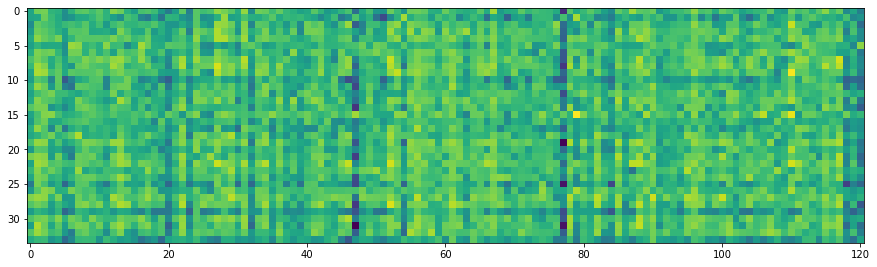

In [20]:
plt.figure(figsize=(15,10))
plt.imshow(gene_fmri_corr)

In [21]:
col_id = 0
Y_ados = df[['ados_css', 'rrb_css', 'sa_css']].values
column_ados = (['ados_css', 'rrb_css', 'sa_css'][col_id])
good_subjects_ados = ~np.isnan(Y_ados)[:,col_id]
Y_use_ados = Y_ados[good_subjects_ados,col_id] 
X_use_ados = gene_fmri_corr[:,good_subjects_ados]
X_use_ados = X_use_ados.transpose()
regression_ados =  linear_model.LinearRegression(normalize=True)
linear_regression_ados = regression_ados.fit(X_use_ados,Y_use_ados) 
Y_use_hat_ados = linear_regression_ados.predict(X_use_ados)

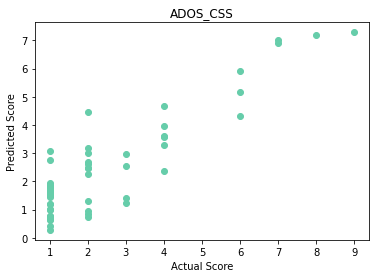

In [22]:
#scatter plot for ados_css
plt.scatter(Y_use_ados,Y_use_hat_ados,color='mediumaquamarine')
plt.title('ADOS_CSS')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.show()

In [23]:
col_id = 1
Y_rrb = df[['ados_css', 'rrb_css', 'sa_css']].values
column_rrb = (['ados_css', 'rrb_css', 'sa_css'][col_id])
good_subjects_rrb = ~np.isnan(Y_rrb)[:,col_id]
Y_use_rrb = Y_rrb[good_subjects_rrb,col_id] 
X_use_rrb = gene_fmri_corr[:,good_subjects_rrb]
X_use_rrb = X_use_rrb.transpose()
regression_rrb =  linear_model.LinearRegression(normalize=True)
linear_regression_rrb = regression_rrb.fit(X_use_rrb,Y_use_rrb) 
Y_use_hat_rrb = linear_regression_rrb.predict(X_use_rrb)

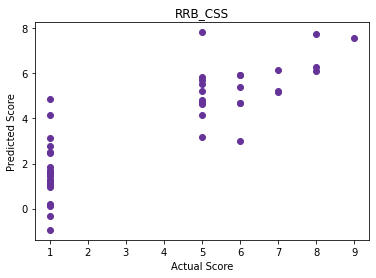

In [24]:
#scatter plot for rrb_css
plt.scatter(Y_use_rrb,Y_use_hat_rrb,color='rebeccapurple')
plt.title('RRB_CSS')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.show()

In [25]:
col_id = 2
Y_sa = df[['ados_css', 'rrb_css', 'sa_css']].values
column_sa = (['ados_css', 'rrb_css', 'sa_css'][col_id])
good_subjects_sa = ~np.isnan(Y_sa)[:,col_id]
Y_use_sa = Y_sa[good_subjects_sa,col_id] 
X_use_sa = gene_fmri_corr[:,good_subjects_sa]
X_use_sa = X_use_sa.transpose()
regression_sa =  linear_model.LinearRegression(normalize=True)
linear_regression_sa = regression_sa.fit(X_use_sa,Y_use_sa) 
Y_use_hat_sa = linear_regression_sa.predict(X_use_sa)

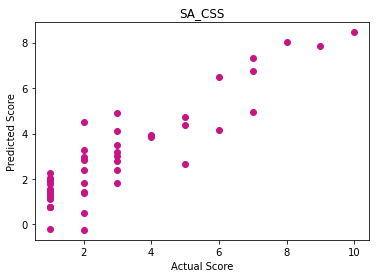

In [26]:
#scatter plot for sa_css
plt.scatter(Y_use_sa,Y_use_hat_sa,color='mediumvioletred')
plt.title('SA_CSS')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.show()

In [27]:
#variance explained for ados_css
from sklearn.metrics import explained_variance_score
ados = explained_variance_score(Y_use_ados,Y_use_hat_ados)*100
print(ados)

79.22289883890814


In [28]:
#variance explained for rrb_css
from sklearn.metrics import explained_variance_score
rrb = explained_variance_score(Y_use_rrb,Y_use_hat_rrb)*100
print(rrb)

74.91152370947096


In [29]:
#variance explained for sa_css
from sklearn.metrics import explained_variance_score
sa = explained_variance_score(Y_use_sa,Y_use_hat_sa)*100
print(sa)

81.60525700337534


Text(0.5, 0, 'Symptom')

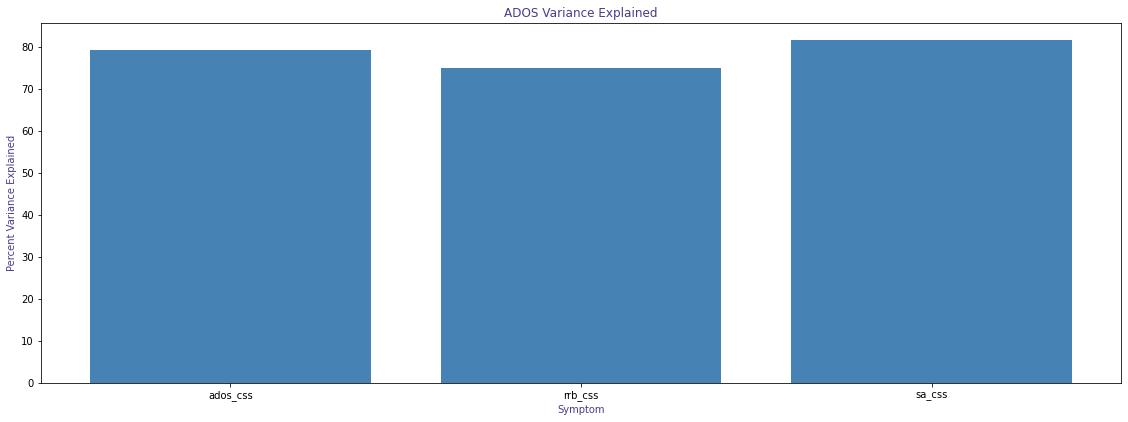

In [30]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
ados_label = ['ados_css', 'rrb_css', 'sa_css']
var_explained = ados, rrb, sa
plt.bar(ados_label,var_explained,color='steelblue')
plt.title('ADOS Variance Explained',color='darkslateblue')
plt.ylabel('Percent Variance Explained',color='darkslateblue')
plt.xlabel('Symptom',color='darkslateblue')

In [31]:
#significance of coefficients for ados_css
print('ADOS_CSS')
X_ados = X_use_ados.copy()
Y_ados = Y_use_ados.copy()
X_ados = sm.add_constant(X_ados)
print(X_ados.shape)
print(Y_ados.shape)

est_ados = sm.OLS(Y_ados, X_ados)
est2_ados = est_ados.fit()
print(est2_ados.summary())

ADOS_CSS
(51, 35)
(51,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     1.794
Date:                Tue, 13 Dec 2022   Prob (F-statistic):              0.107
Time:                        12:12:22   Log-Likelihood:                -69.165
No. Observations:                  51   AIC:                             208.3
Df Residuals:                      16   BIC:                             275.9
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9957      1

In [32]:
labels = ['CDIPT','CORO1A','ATXN2L','ZG16','ALDOA','CYFIP1','QRPT','SH2B1','SEZ6L2','LAT','KIF22','MAZ','ATP2A1','PPP4C','GDPD3','MAPK3','RABEP2','NIPA2','YPEL3','SPNS1','NFATC2IP','SPN','TUFM','PRRT2','TUBGCP5','NIPA1','TMEM219','DOC2A','HIRIP3','KCTD13','ASPHD1','TAOK2','CD19','MVP']
def plot_errorbar_from_table(est2_ados,labels):
    coef_ados = est2_ados.params[1::]
    ci_ados = est2_ados.conf_int()[1::,:]
    ci_rel_ados = abs(np.vstack((coef_ados,coef_ados)).transpose() - ci_ados)
    ci_rel_ados = ci_rel_ados.transpose()
    xs_ados = np.arange(len(coef_ados))

    plt.figure(figsize=(25,10))
    plt.bar(xs_ados,coef_ados,color='silver')
    plt.errorbar(xs_ados,coef_ados,ci_rel_ados,fmt='r ',capsize=10,ecolor='darkgrey')
    plt.xticks(xs_ados,labels=labels);

Text(0.5, 0, 'Gene')

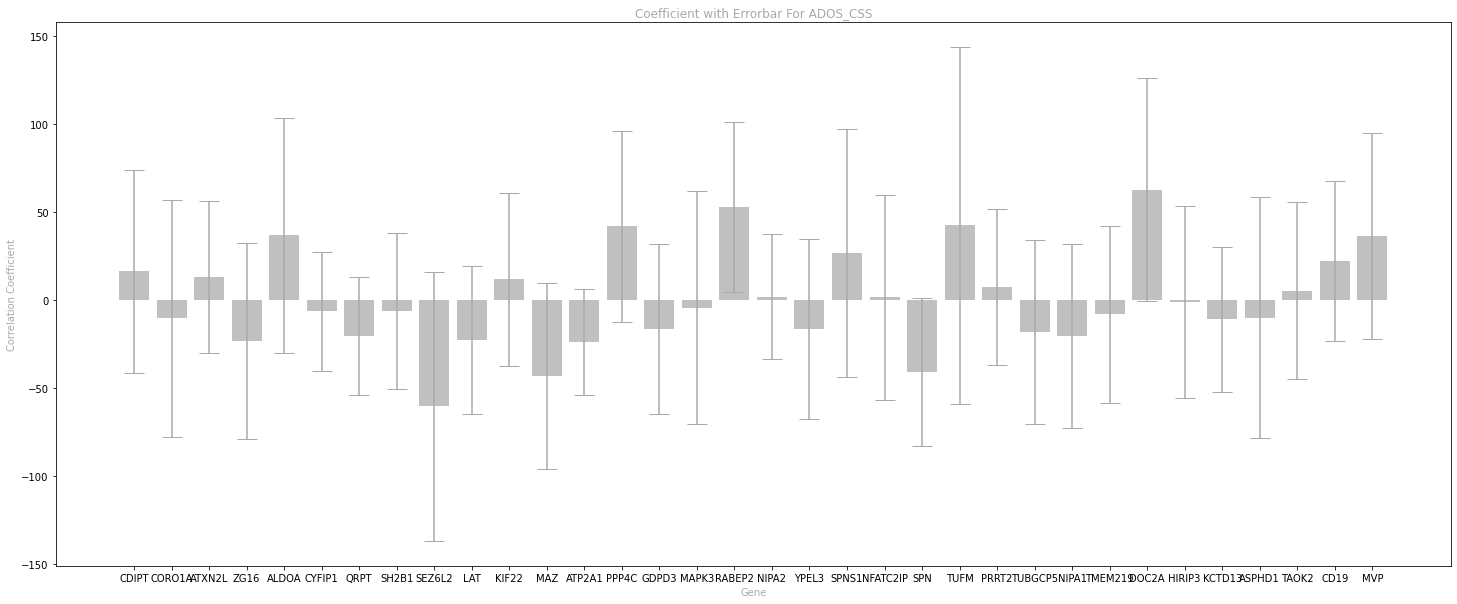

In [33]:
plot_errorbar_from_table(est2_ados,labels)
plt.title('Coefficient with Errorbar For ADOS_CSS',color='darkgrey')
plt.ylabel('Correlation Coefficient',color='darkgrey')
plt.xlabel('Gene',color='darkgrey')

In [34]:
#significance of coefficients for rrb_css
print('RRB_CSS')
X_rrb = X_use_rrb.copy()
Y_rrb = Y_use_rrb.copy()
X_rrb = sm.add_constant(X_rrb)
print(X_rrb.shape)
print(Y_rrb.shape)

est_rrb = sm.OLS(Y_rrb, X_rrb)
est2_rrb = est_rrb.fit()
print(est2_rrb.summary())

RRB_CSS
(51, 35)
(51,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     1.405
Date:                Tue, 13 Dec 2022   Prob (F-statistic):              0.237
Time:                        12:12:22   Log-Likelihood:                -86.981
No. Observations:                  51   AIC:                             244.0
Df Residuals:                      16   BIC:                             311.6
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.3119      2.

In [35]:
def plot_errorbar_from_table(est2_rrb,labels):
    coef_rrb = est2_rrb.params[1::]
    ci_rrb = est2_rrb.conf_int()[1::,:]
    ci_rel_rrb = abs(np.vstack((coef_rrb,coef_rrb)).transpose() - ci_rrb)
    ci_rel_rrb = ci_rel_rrb.transpose()
    xs_rrb = np.arange(len(coef_rrb))

    plt.figure(figsize=(25,10))
    plt.bar(xs_rrb,coef_rrb,color='lightpink')
    plt.errorbar(xs_rrb,coef_rrb,ci_rel_rrb,fmt='r ',capsize=10,ecolor='crimson')
    plt.xticks(xs_rrb,labels=labels);

Text(0.5, 0, 'Gene')

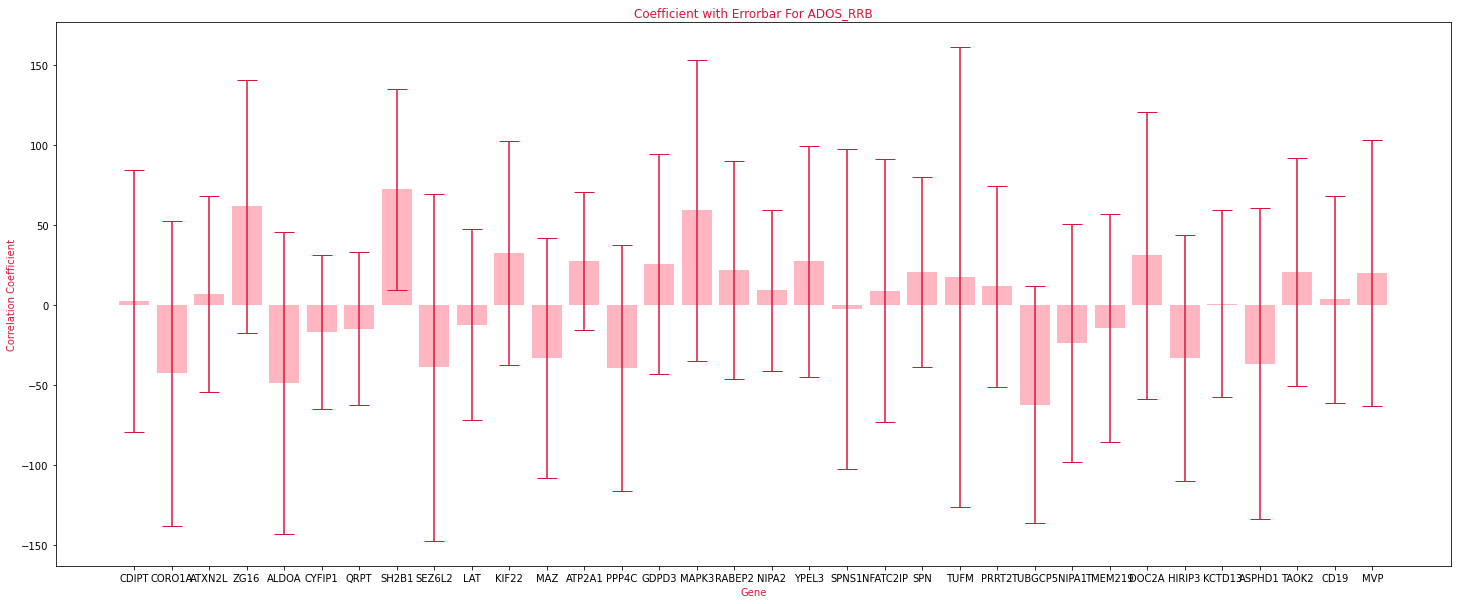

In [36]:
plot_errorbar_from_table(est2_rrb,labels)
plt.title('Coefficient with Errorbar For ADOS_RRB',color='crimson')
plt.ylabel('Correlation Coefficient',color='crimson')
plt.xlabel('Gene',color='crimson')

In [37]:
#significance of coefficients for sa_css
print('SA_CSS')
X_sa = X_use_sa.copy()
Y_sa = Y_use_sa.copy()
X_sa = sm.add_constant(X_sa)

est_sa = sm.OLS(Y_sa, X_sa)
est2_sa = est_sa.fit()
print(est2_sa.summary())

SA_CSS
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     2.088
Date:                Tue, 13 Dec 2022   Prob (F-statistic):             0.0592
Time:                        12:12:23   Log-Likelihood:                -72.326
No. Observations:                  51   AIC:                             214.7
Df Residuals:                      16   BIC:                             282.3
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8630      1.614      0.535  

In [38]:
def plot_errorbar_from_table(est2_sa,labels):
    coef_sa = est2_sa.params[1::]
    ci_sa = est2_sa.conf_int()[1::,:]
    ci_rel_sa = abs(np.vstack((coef_sa,coef_sa)).transpose() - ci_sa)
    ci_rel_sa = ci_rel_sa.transpose()
    xs_sa = np.arange(len(coef_sa))

    plt.figure(figsize=(25,10))
    plt.bar(xs_sa,coef_sa,color='thistle')
    plt.errorbar(xs_sa,coef_sa,ci_rel_sa,fmt='r ',capsize=10,ecolor='rebeccapurple')
    plt.xticks(xs_sa,labels=labels);

Text(0.5, 0, 'Gene')

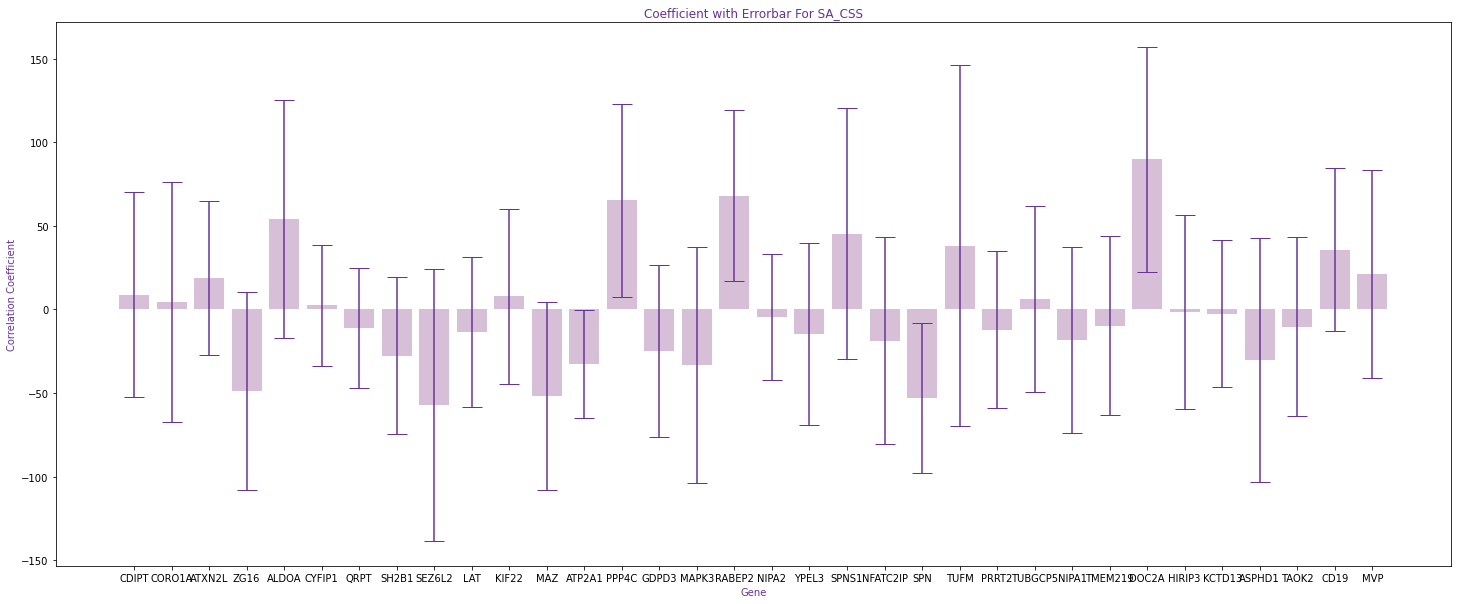

In [39]:
plot_errorbar_from_table(est2_sa,labels)
plt.title('Coefficient with Errorbar For SA_CSS',color='rebeccapurple')
plt.ylabel('Correlation Coefficient',color='rebeccapurple')
plt.xlabel('Gene',color='rebeccapurple')